In [1]:
# RRM nUSP 6516211
# SCC5830 (2022/1)
# Final Project = Morphological characterization of bird droppings using img. proc. techniques

# #Objectives:
# a) total area, area of solid green phase, area of the white on liquid phase;
# b) presence and intensity of red (indicative of blood);
# c) presence of 'dots' from undigested food on the solid phase;
# d) nº of segments of the solid part;

# #Overview of steps:
# * remove background
# * (a) from not bg isolate ref rectangle and count its pixels
# * (a,d) isolate all poop and normalize
#   - count its pixels
#   - spread/texture measurement (diarhea measurement)
#   - overall parameter to directly compare with other images:
#       . hist 95% confidence distances
#       . Haralick or bag of features 95% confid distances
#       . fourier 95% confid distances
# * from all poop isolate green poop:
#   - (a) count its pixels
#   - (d) spread/texture measurement
#   - (b) redish histogram
#   - (c) histogram
# * from all poop isolate white and yellowish histogram

# #Overview of development
# I started developing the code before the lessons of segmentation, so I've ended developing an alternative way to image segmentation.
# This alternative way is poor in performance and will be changed, but I've decided to keep in this partial step for documentation.
# The first step was to explore the image to gain insights on how to segment using the information of color, since the intuitive human perception probably use this info in this case.
# Channels of RGB and HSV spaces were observed.
# Two functions called 'white_limiar' and 'color_limiar' where created to segment the background and the reference card, respectivelly.
# From the image with the segmented reference card of a known size, the conversion factor mm²/pixel was calculated.
# It appears to be reasonable to assume a constant factor for the image because the image is plain (constant focal distance for the entire frame).
# A low pass filter was used to try to segment the reference card, but it was not sucessful
# The green and red histograms were also explored.

In [20]:
img_hsv = mpl.colors.rgb_to_hsv(img_in)
np.logical_and(img_hsv)
#mpl.colors.rgb_to_hsv((2, 96, 62))[0]

0.43971631205673756

In [1]:
import numpy as np
import imageio
import matplotlib as mpl, matplotlib.pyplot as plt
#import matplotlib as mpl

In [2]:
# from platform import python_version ; print(python_version() == '3.9.2')
# print(np.__version__ == '1.22.3')
# print(imageio.__version__ == '2.16.1')
# import matplotlib ; print(matplotlib.__version__ == '3.5.1')

In [26]:
# Read input
#img_in = (imageio.imread("sample-imgs/sample-photo1-crop.jpg")).astype(np.uint8)
img_in = (imageio.imread("img-db/IMG_8777.JPG")).astype(np.uint8)
ref_size = 86 * 55 #[mm]

(2848, 4272, 3) 6 255


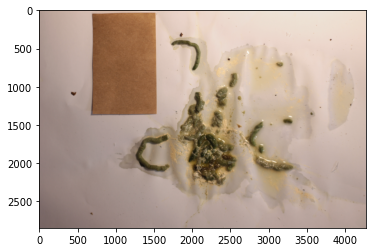

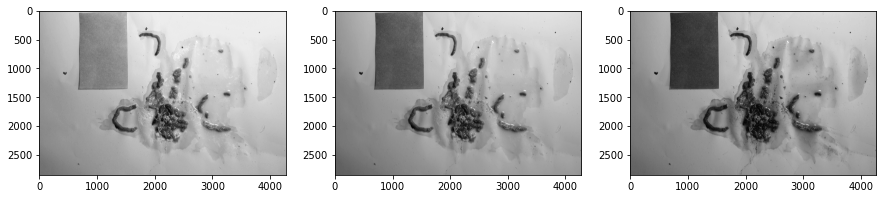

In [27]:
print(img_in.shape, np.min(img_in), np.max(img_in))
#plt.figure(figsize=(5,8))
plt.imshow(img_in)
plt.figure(figsize=(15,5))
plt.subplot(131); plt.imshow(img_in[:,:,0], cmap='gray')
plt.subplot(132); plt.imshow(img_in[:,:,1], cmap='gray')
plt.subplot(133); plt.imshow(img_in[:,:,2], cmap='gray')

In [ ]:
img_hsv = mpl.colors.rgb_to_hsv(img_in)
plt.figure(figsize=(15,5))
plt.subplot(131); plt.imshow(img_hsv[:,:,0], cmap='hsv'); plt.colorbar()
plt.subplot(132); plt.imshow(img_hsv[:,:,1], cmap='gray'); plt.colorbar(); plt.title("Saturation")
plt.subplot(133); plt.imshow(img_hsv[:,:,2], cmap='gray'); plt.colorbar(); plt.title("Value")

In [6]:
def img_norm(im, high=255):  # Normalize and coerce to uint8
    im_low = im-np.min(im)  # Shift the low value to 0
    im_norm = (im_low*high/np.max(im_low)).astype(np.uint8)  # Adjust the range to a maximum of 255
    return im_norm

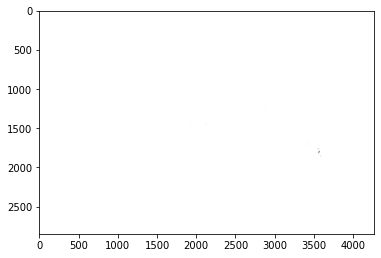

In [7]:
c1 = 0.7
c2 = 80
condition = (img_hsv[:,:,1] > c1) & ((img_hsv[:,:,2] < c2) | (img_hsv[:,:,2] > 200))
idx_filter = np.where(condition)
    
img_temp = (255*np.ones(img_in.shape).astype(np.uint8))
img_temp[idx_filter] = img_in[idx_filter]
#img_temp = img_norm(img_temp)
plt.figure(figsize=(6,15))
plt.imshow(img_temp)#[:,:,2], cmap='gray');# plt.colorbar()
#imageio.imsave("sel2.jpg",img_temp)

In [8]:
def limiar_search(img_ipt, t0=120, print_t=False):  # Otsu segmentation
    search_t = True
    t = t0  # inital threshold
    while search_t:
        g1 = img_ipt[img_ipt > t]
        g2 = img_ipt[img_ipt <= t]
        
        mu1 = g1.mean()
        mu2 = g2.mean()
        
        t_old = t
        t = 0.5*(mu1+mu2)
        
        if abs(t-t_old) < 0.5:
            search_t = False
    
    img_out = np.zeros(img_ipt.shape)
    img_out[img_ipt > t] = 255
    if print_t:
        print(t)
    
    return img_out.astype(np.uint8)

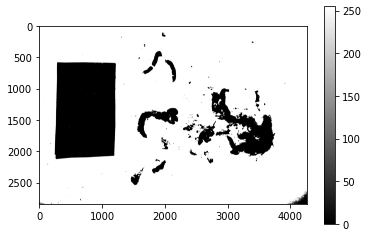

In [9]:
plt.imshow(limiar_search(img_in[:,:,0]*0.299 + img_in[:,:,1]*0.587 + img_in[:,:,2]*0.114), cmap='gray'); plt.colorbar()

98.46888020993403


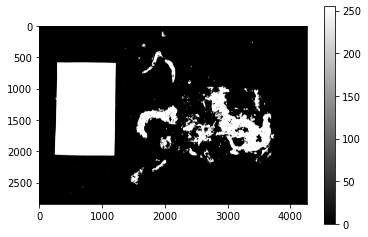

In [10]:
plt.imshow(limiar_search(img_norm(img_hsv[:,:,1]), print_t=True), cmap='gray'); plt.colorbar()

In [11]:
def limiar_range(img_ipt, t, ranget):
    img_out = np.zeros(img_ipt.shape)
    img_out[(img_ipt > t - ranget) & (img_ipt < t + ranget)] = 255

    return img_out

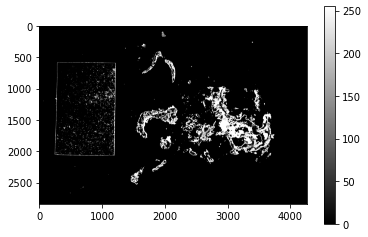

In [12]:
plt.imshow(limiar_range(img_norm(img_hsv[:,:,1]), 130, 30), cmap='gray'); plt.colorbar()

In [13]:
pixel_to_area = ref_size/np.sum(limiar_range(img_norm(img_hsv[:,:,1]), 130, 30) > 250)

In [14]:
"{:.2} [mm/pixel]".format(pixel_to_area)

'0.0076 [mm/pixel]'

In [15]:
def color_limiar(img, color, threshold=0.05):
    # ''''
    # Funcion to apply limiarization for a given color and threshold/tolerance value
    # * Color: must be a tuple with rgb values of the desired color selector
    # * Threshold is the fracion of hue spectrum to filter
    # ''''
    
    c = mpl.colors.rgb_to_hsv(color)[0]
    
    img_hsv = mpl.colors.rgb_to_hsv(img)
    condition = np.logical_and(img_hsv[:,:,0] < c + threshold/2,
                             img_hsv[:,:,0] > c - threshold/2)
    idx_filter = np.where(condition)
    
    img_out = np.zeros(img.shape).astype(np.uint8)
    img_out[idx_filter] = img[idx_filter]
    
    return img_out

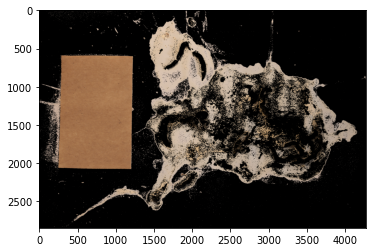

In [16]:
plt.imshow(color_limiar(img_in, (181,101,29), 0.03))

In [17]:
def white_limiar(img, whitelvl, threshold=0.05):
    # ''''
    # Funcion to apply limiarization for white color and threshold/tolerance value
    # * Whitelvl: float from 0 to 1 expressing the level of white to filter
    # * Threshold is the fracion of white spectrum to filter
    # ''''
    
    c = whitelvl
    
    img_float = img.astype(float)/255
    condition0 = (img_float[:,:,0] < c + threshold/2) & (img_float[:,:,0] > c - threshold/2)
    condition1 = (img_float[:,:,1] < c + threshold/2) & (img_float[:,:,1] > c - threshold/2)
    condition2 = (img_float[:,:,2] < c + threshold/2) & (img_float[:,:,2] > c - threshold/2)
    condition = condition0 & condition1 & condition2
    idx_filter = np.where(condition)
    
    img_out = np.zeros(img.shape).astype(np.uint8)
    img_out[idx_filter] = img[idx_filter]
    
    return img_out

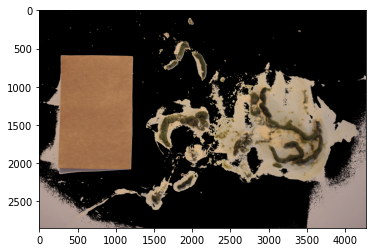

In [18]:
img_nobk = img_in - white_limiar(img_in, 0.8, 0.4)
plt.imshow(img_nobk)

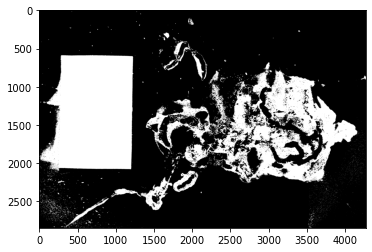

In [19]:
sqr_img = limiar_search(color_limiar(img_nobk, (181,101,29), 0.05)[:,:,1])
plt.imshow(sqr_img, cmap='gray')

((2848, 4272), 20.508089525221422, 3.620946130735664)

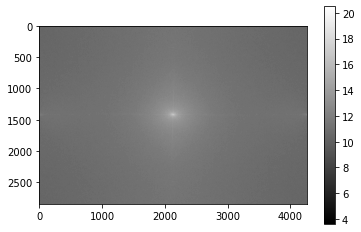

In [20]:
# Fourier transform of input image
spec_freq_0 = np.fft.fft2(sqr_img, s=sqr_img.shape)
spec_freq_c = np.fft.fftshift(spec_freq_0)
spec_freq_log = np.log(spec_freq_c)
plt.imshow(spec_freq_log.real, cmap="gray")
plt.colorbar()
spec_freq_log.real.shape, np.max(spec_freq_log.real), np.min(spec_freq_log.real)

(2848, 4272) 1.0 0.0


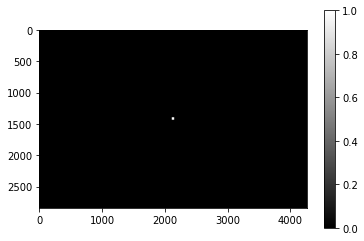

In [21]:
# Pad the filter so it has the same size as input image
size = 40
p = np.ones((size,size)).astype(np.uint8)

sizein = 3
pin = np.zeros((sizein,sizein)).astype(np.uint8)

centerp = int(size/2 - sizein/2)
p[:sizein,:sizein] = pin
p = np.roll(p, (centerp, centerp), axis=(0,1))

centerx = int(img_in[:,:,0].shape[0]/2 - size/2)
centery = int(img_in[:,:,0].shape[1]/2 - size/2)

p_pad = np.zeros(img_in[:,:,0].shape)
p_pad[:p.shape[0],:p.shape[0]] = p
p_pad = np.roll(p_pad, (centerx, centery), axis=(0,1))
print(p_pad.shape, np.max(p_pad), np.min(p_pad))
plt.imshow(p_pad, cmap="gray"); plt.colorbar()

In [22]:
spec_new = np.multiply(p_pad, spec_freq_log)
#plt.imshow(spec_new.real, cmap="gray")
#plt.colorbar()
#spec_new.shape, np.max(spec_new), np.min(spec_new)

((2848, 4272), 255, 0)

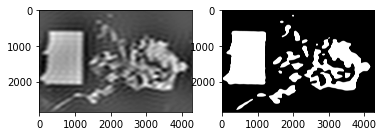

In [23]:
nspec_freq_c = np.exp(spec_new)
nspec_freq_0 = np.fft.ifftshift(nspec_freq_c)
img_out = img_norm(np.fft.ifft2(nspec_freq_0).real,255)
plt.subplot(121); plt.imshow(img_out, cmap="gray")
plt.subplot(122); plt.imshow(limiar_search(img_out), cmap="gray")
#plt.colorbar()
img_out.shape, np.max(img_out), np.min(img_out)

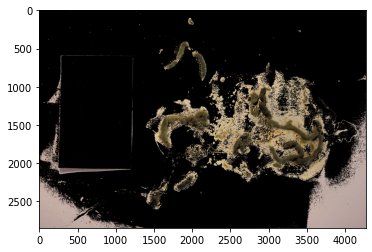

In [24]:
infos = np.where(img_nobk > 0, True, False)
card = np.where(color_limiar(img_in, (181,101,29), 0.03) > 0, True, False)
poop = infos & np.logical_not(card)
img_poop = np.zeros(img_nobk.shape)
img_poop[poop] = img_nobk[poop]
plt.imshow(img_norm(img_poop))
imageio.imsave("sel.jpg",img_norm(img_poop))

<BarContainer object of 64 artists>

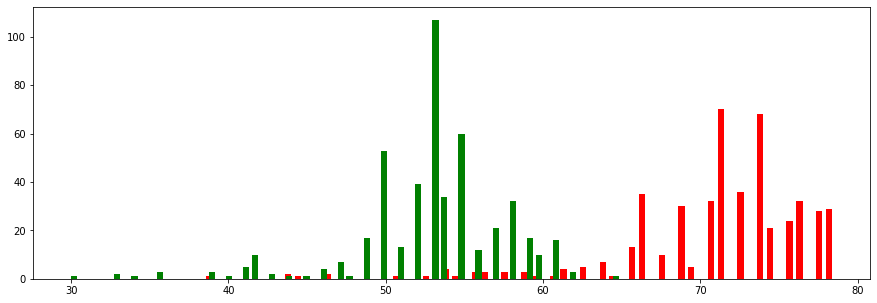

In [25]:
img_poop_r = img_temp[:,:,0]
img_poop_g = img_temp[:,:,1]

hist_r = np.histogram(img_poop_r[(img_poop_r > 5) & (img_poop_r < 250)], bins=64)
hist_g = np.histogram(img_poop_g[(img_poop_g > 5) & (img_poop_g < 250)], bins=64)

plt.figure(figsize=(15,5))
plt.bar(hist_r[1][:-1]-0.2,hist_r[0], 0.4, color='red')
plt.bar(hist_g[1][:-1]+0.2,hist_g[0], 0.4, color='green')